# 🔭 **Overview**

This notebook performs a comprehensive exploratory data analysis (EDA) of solar energy production data to understand the dataset structure, key patterns, and the relationships between features and the target variable (`% Baseline`). The analysis includes an initial examination of the train and test sets, an exploration of the target distribution and its most suitable transformations, correlation analysis, and the study of temporal patterns such as monthly and diurnal cycles. 

The notebook also identifies redundant features such as temperature, pressure, and wind speed, and examines physical and astronomical factors that influence solar production such as irradiance and cloud cover. Time series characteristics are analyzed as well to capture the dynamic behavior of solar energy output. These insights provide a strong foundation for decisions on preprocessing, feature engineering, and model training.

# 📚 **Library and Configuration**

This analysis leverages key Python libraries for data manipulation and visualization: `pandas` for data handling, `seaborn` and `matplotlib` for creating insightful visualizations, and `numpy` for numerical operations. Additionally, we utilize a custom module `src.exploration` containing specialized helper functions designed to streamline the exploratory analysis workflow, enabling efficient feature comparisons, correlation analysis, and temporal pattern visualization.

In [102]:
# System & Environment Configuration
import sys
import importlib
sys.path.append("..")

# Ignore warning
from warnings import filterwarnings
filterwarnings("ignore")

# Core Library
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Source helper
import src.exploration as explore
def r(module=explore):
    importlib.reload(module)

r()

# Defaults
sns.set_style('whitegrid')

# Train and Test Processed
PROCESSED_ROOT = Path('../data/processed/')

TRAIN_PATH_PROCESSED = PROCESSED_ROOT/'train.csv'
TEST_PATH_PROCESSED = PROCESSED_ROOT/'test.csv'

# Figures Path
FIGURE_PATH = Path('../reports/figures')

print('library and configuration ready!')

library and configuration ready!


# 🗃️ **Train and Test Loading**

In [103]:
train = pd.read_csv(TRAIN_PATH_PROCESSED)
test = pd.read_csv(TEST_PATH_PROCESSED)

print('Train shape :', train.shape)
print('Test Shape  :', test.shape)

Train shape : (18942, 39)
Test Shape  : (1077, 39)


For streamlined analysis, we separate features (`X`) and target (`y`) from the training set. This approach enables flexible visualization and analysis, allowing us to examine feature distributions independently, compute feature-target correlations efficiently, and conduct targeted preprocessing without redundantly handling the target var

In [104]:
# For a flexible exploration, we can separate features and target
TARGET = '% Baseline'

X=train.drop(columns=[TARGET])
y=train[TARGET]

print('Train features shape :', X.shape)
print('Train target shape   :', y.shape)

Train features shape : (18942, 38)
Train target shape   : (18942,)


# 📊 **General Analysis**

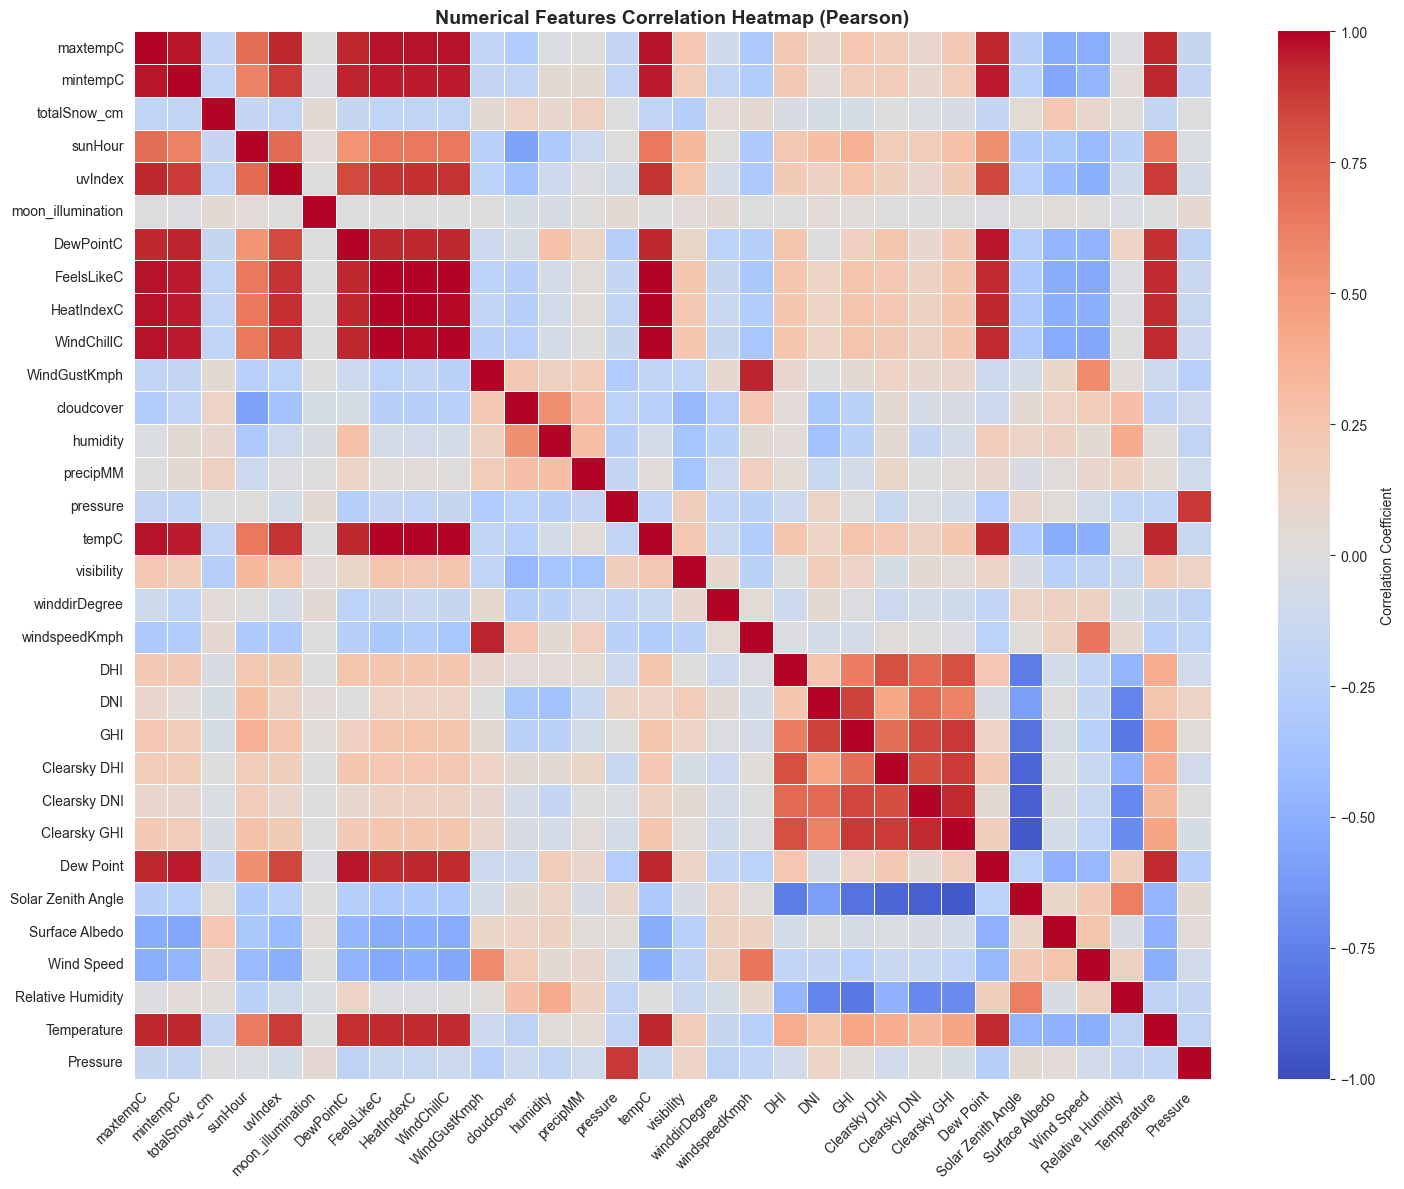

In [80]:
numerical_features = X.select_dtypes(np.number).columns

explore.plot_numerical_correlation(
    X, numerical_features,
    save_path=FIGURE_PATH/'general/feature_correlation.png')

plt.show()

Irradiance variables (`GHI`, `DNI`, `DHI` and their clearsky counterparts) form a tight cluster and dominate the covariance structure; `Solar Zenith Angle` is strongly (inversely) associated with these irradiance measures, so solar geometry clearly drives most of the signal. Temperature-related fields (`tempC`, `Temperature`, `maxtempC`, `HeatIndexC`, `DewPointC`) are strongly correlated among themselves and show a modest association with the target, indicating thermal effects are secondary to irradiance for % Baseline. Cloud indicators (`cloudcover`, `Cloud Type`) are negatively correlated with irradiance and the target, while `windspeed/Wind Speed` pair together but only weakly relate to `% Baseline`. In short: irradiance features are the primary drivers, with clear redundant groups (temperature, clearsky duplicates, wind measures) present.

# 📈 **Target Inspections**

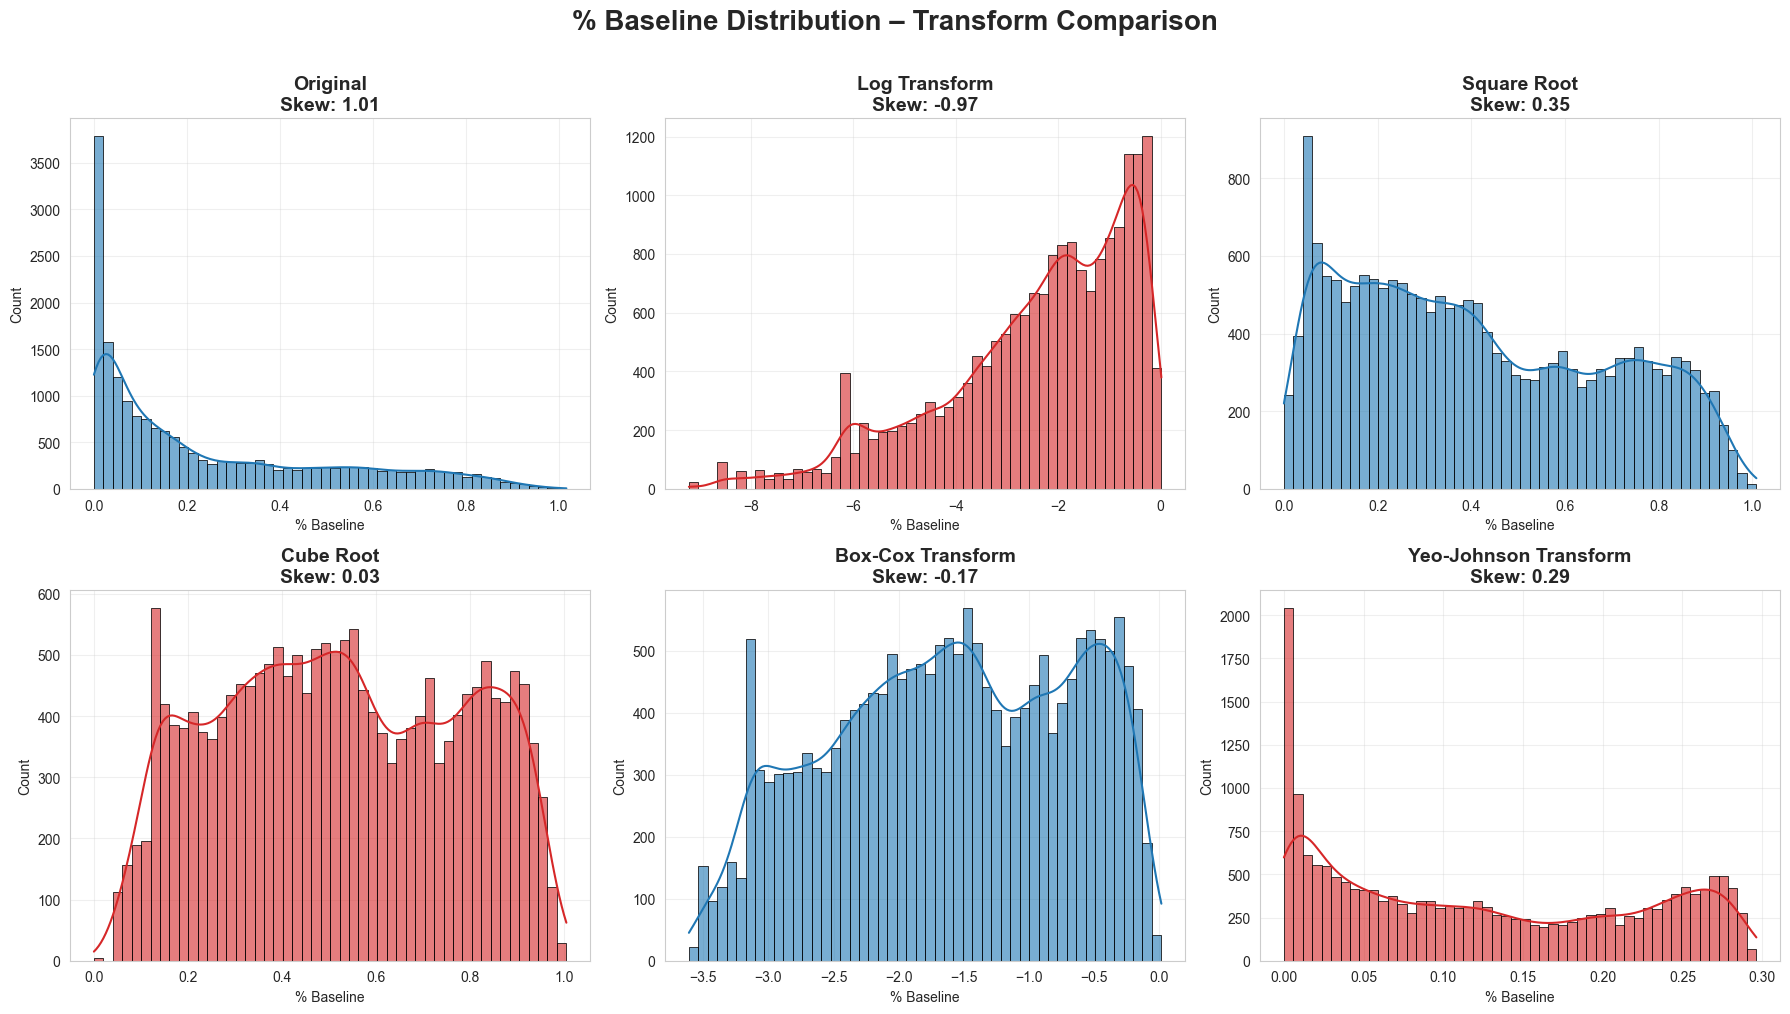

In [81]:
explore.check_transformations(
    y, TARGET, save_path=FIGURE_PATH/'general/target_dist.png',
    transforms=["original", "log", "sqrt", "cbrt", "boxcox", "yeojohnson"]
    )

The original distribution is right-skewed (skew: 1.01), with most energy output clustered at low values. The Cube Root (skew: 0.03) and Box-Cox (skew: -0.17) transformations best normalize the distribution, making them ideal choices for modeling.

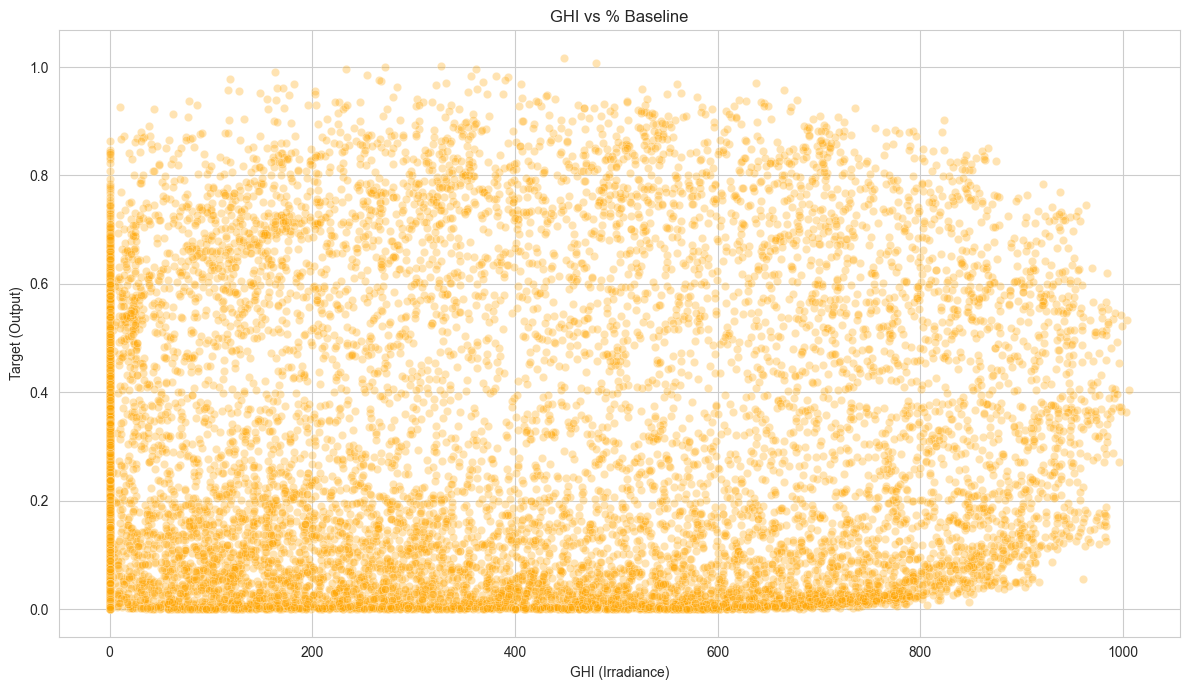

In [82]:
plt.figure(figsize=(12, 7))

# Scatter plot GHI vs Target
sns.scatterplot(x=train['GHI'], y=train[TARGET], alpha=0.3, color='orange')
plt.title(f"GHI vs {TARGET}")
plt.xlabel("GHI (Irradiance)")
plt.ylabel("Target (Output)")
plt.savefig(FIGURE_PATH/'general/GHI_vs_energy.png', dpi=300)

plt.tight_layout()
plt.show()

Strong positive correlation between GHI (Global Horizontal Irradiance) and energy output, confirming irradiance is the primary driver of solar production. The relationship shows some scatter at higher irradiance levels, indicating other factors (clouds, temperature, efficiency losses) modulate the output.

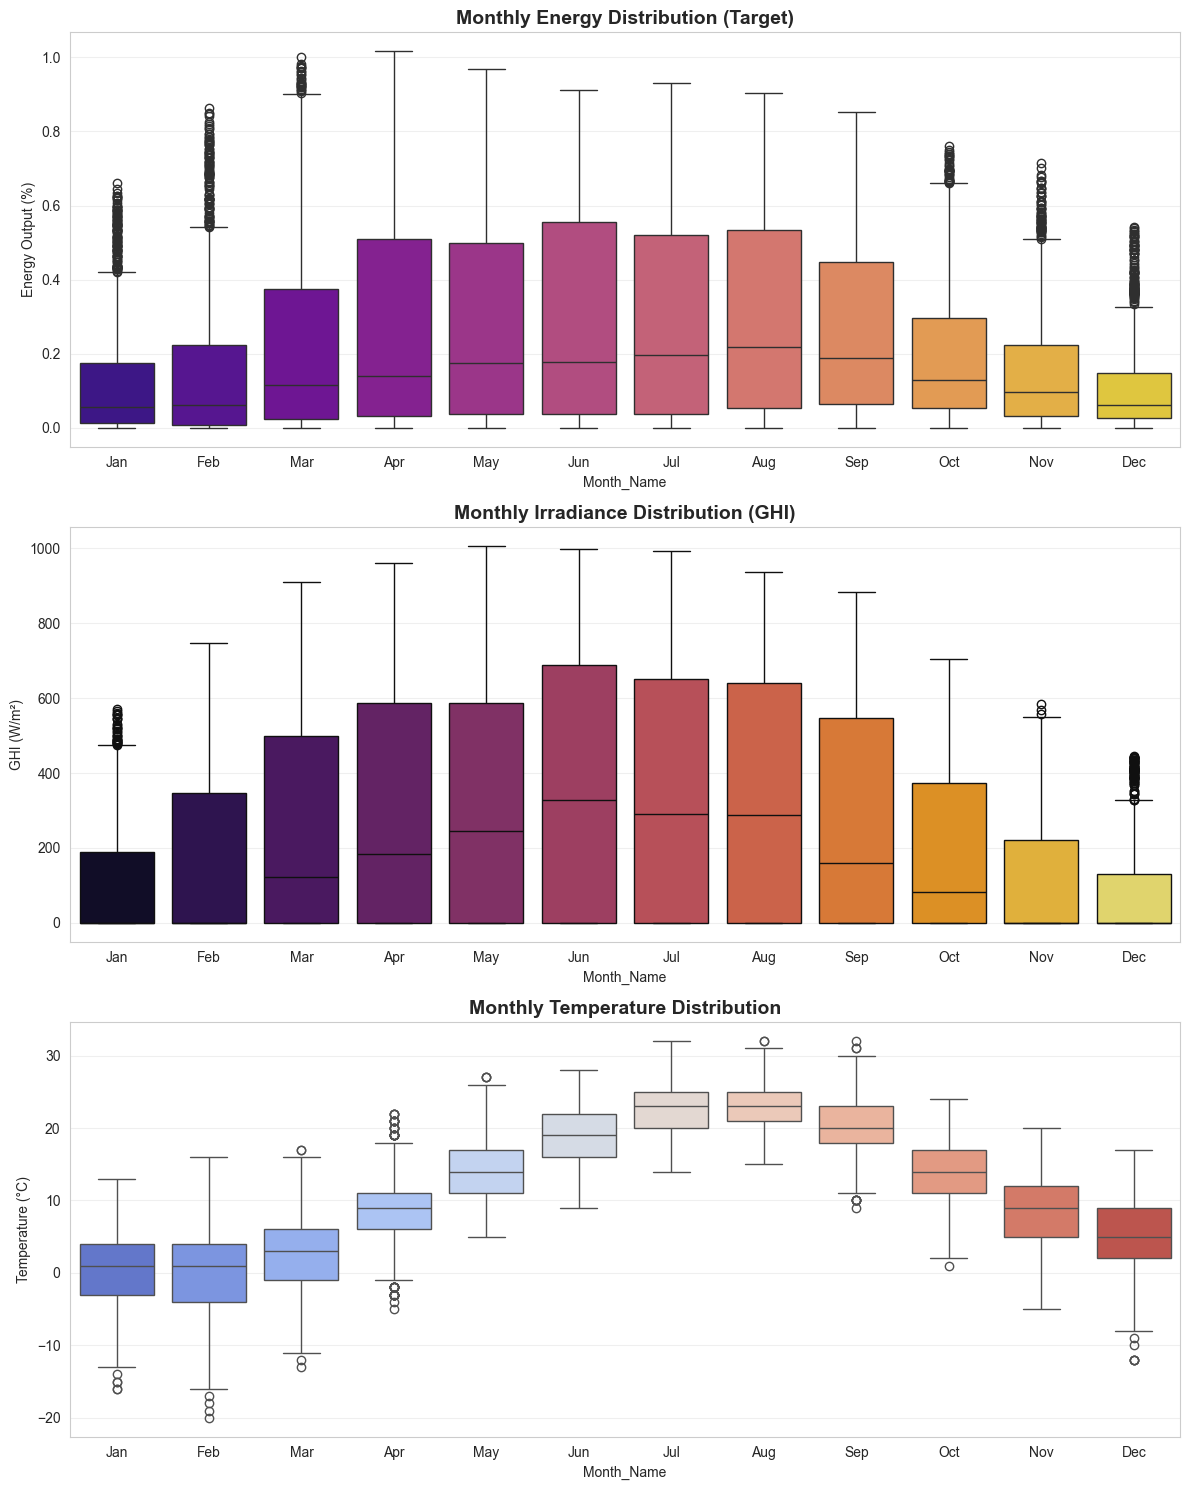

In [83]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Monthly target
explore.plot_monthly_boxplot(
    train, col='% Baseline',
    title='Monthly Energy Distribution (Target)',
    ylabel='Energy Output (%)',
    palette='plasma', ax=axes[0],
    save_path=FIGURE_PATH/'monthly/energy.png'
)

# Monthly GHI
explore.plot_monthly_boxplot(
    train, col='GHI',
    title='Monthly Irradiance Distribution (GHI)',
    ylabel='GHI (W/m²)',
    palette='inferno', ax=axes[1],
    save_path=FIGURE_PATH/'monthly/GHI.png'
)

# Monthly temperature
explore.plot_monthly_boxplot(
    train, col='tempC',
    title='Monthly Temperature Distribution',
    ylabel='Temperature (°C)',
    palette='coolwarm', ax=axes[2],
    save_path=FIGURE_PATH/'monthly/temperature.png'
)

plt.tight_layout()
plt.show()

Both `% Baseline` and `GHI` show pronounced seasonal variation, peaking during summer months (May-August) when solar angles are higher and daylight is longer, then declining through winter. `tempC` also follows this seasonal cycle. While `tempC` and `GHI` are seasonally coupled, temperature's direct impact on output is secondary the scatter in the `GHI`-`% Baseline` relationship shows that at similar temperatures, output varies significantly, indicating `GHI` remains the dominant factor governing energy production.

# 🤝 **Exploration for Similar Features**

We found several near-duplicate features because the training set was created by merging two separate sources, a weather dataset and a solar irradiance dataset on timestamps. Each source can contain measurements of the same physical quantity (e.g., temperature, pressure, dew point) recorded by different sensors or preprocessed differently; this explains why pairs like `Temperature`/`tempC` and `pressure`/`Pressure` appear similar but not always identical.

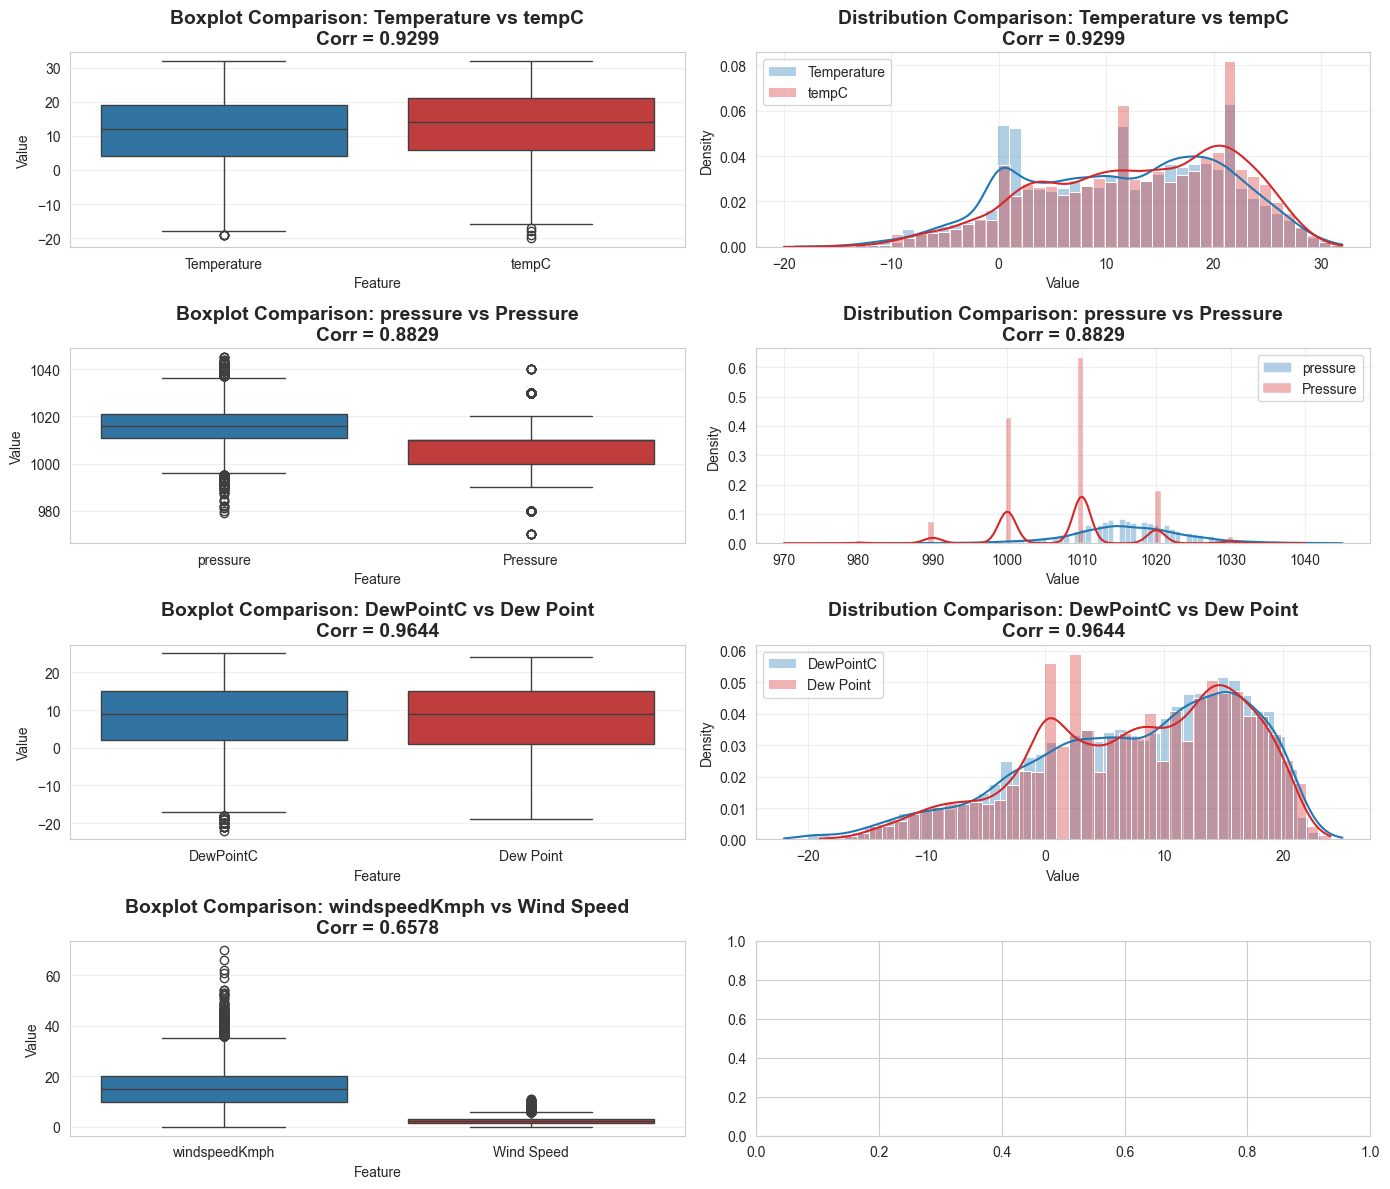

In [84]:
fig, axes = plt.subplots(4, 2, figsize=(14, 12))

# Temperature
explore.compare_features_boxplot(
    train, ['Temperature','tempC'], ax=axes[0,0],
    save_path=FIGURE_PATH/'similar/box_temperature.png')
explore.compare_features_distribution(
    train, ['Temperature','tempC'], ax=axes[0,1],
    save_path=FIGURE_PATH/'similar/dist_temperature.png')

# Pressure
explore.compare_features_boxplot(
    train, ['pressure','Pressure'], ax=axes[1,0],
    save_path=FIGURE_PATH/'similar/box_pressure.png')
explore.compare_features_distribution(
    train, ['pressure','Pressure'], ax=axes[1,1],
    save_path=FIGURE_PATH/'similar/dist_pressure.png')

# Dew Point
explore.compare_features_boxplot(
    train, ['DewPointC','Dew Point'], ax=axes[2,0],
    save_path=FIGURE_PATH/'similar/box_dewpoint.png')
explore.compare_features_distribution(
    train, ['DewPointC','Dew Point'], ax=axes[2,1],
    save_path=FIGURE_PATH/'similar/dist_dewpoint.png')

# Wind
explore.compare_features_boxplot(
    train, ['windspeedKmph','Wind Speed'], ax=axes[3,0],
    # save_path=FIGURE_PATH/'similar/box_dewpoint.png'
    )

plt.tight_layout()
plt.show()

We'll keep one representative variable from each redundant group: `Temperature`, `pressure`, and `Dew Point` (with clear outliers removed before modeling). Choosing a single canonical feature per group reduces multicollinearity while preserving the underlying physical signal; if later experiments show benefit from source-specific fields, we can reintroduce them selectively.

In [85]:
# Convert to kmph
train['Wind Speed'] = train['Wind Speed']*(3.6)

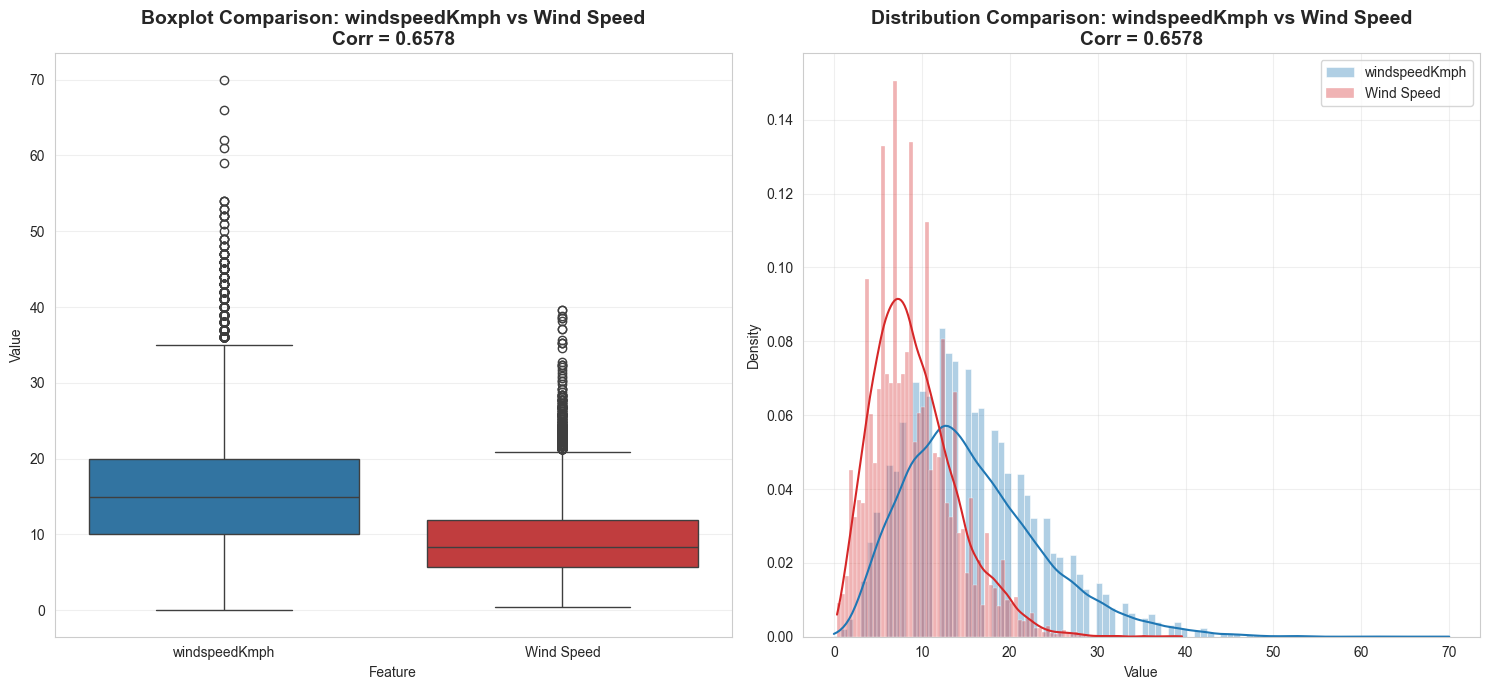

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

explore.compare_features_boxplot(
    train, ['windspeedKmph','Wind Speed'], ax=axes[0],
    save_path=FIGURE_PATH/'similar/box_windspeed.png'
    )

explore.compare_features_distribution(
    train, ['windspeedKmph','Wind Speed'], ax=axes[1],
    save_path=FIGURE_PATH/'similar/dist_windspeed.png'
    )

plt.tight_layout()
plt.show()

For `windspeedKmph` and `Wind Speed` we will retain both fields during initial modeling. Although converting `Wind Speed` (m/s) to km/h (`Wind Speed` × 3.6) aligns units, the two measurements may come from different sensors or ingestion pipelines and can capture subtle timing/provenance differences useful for QA and model signals; keep both for now and reassess later if redundancy adversely affects performance.

# 🌘 **Astronomical and Physical Analysis**

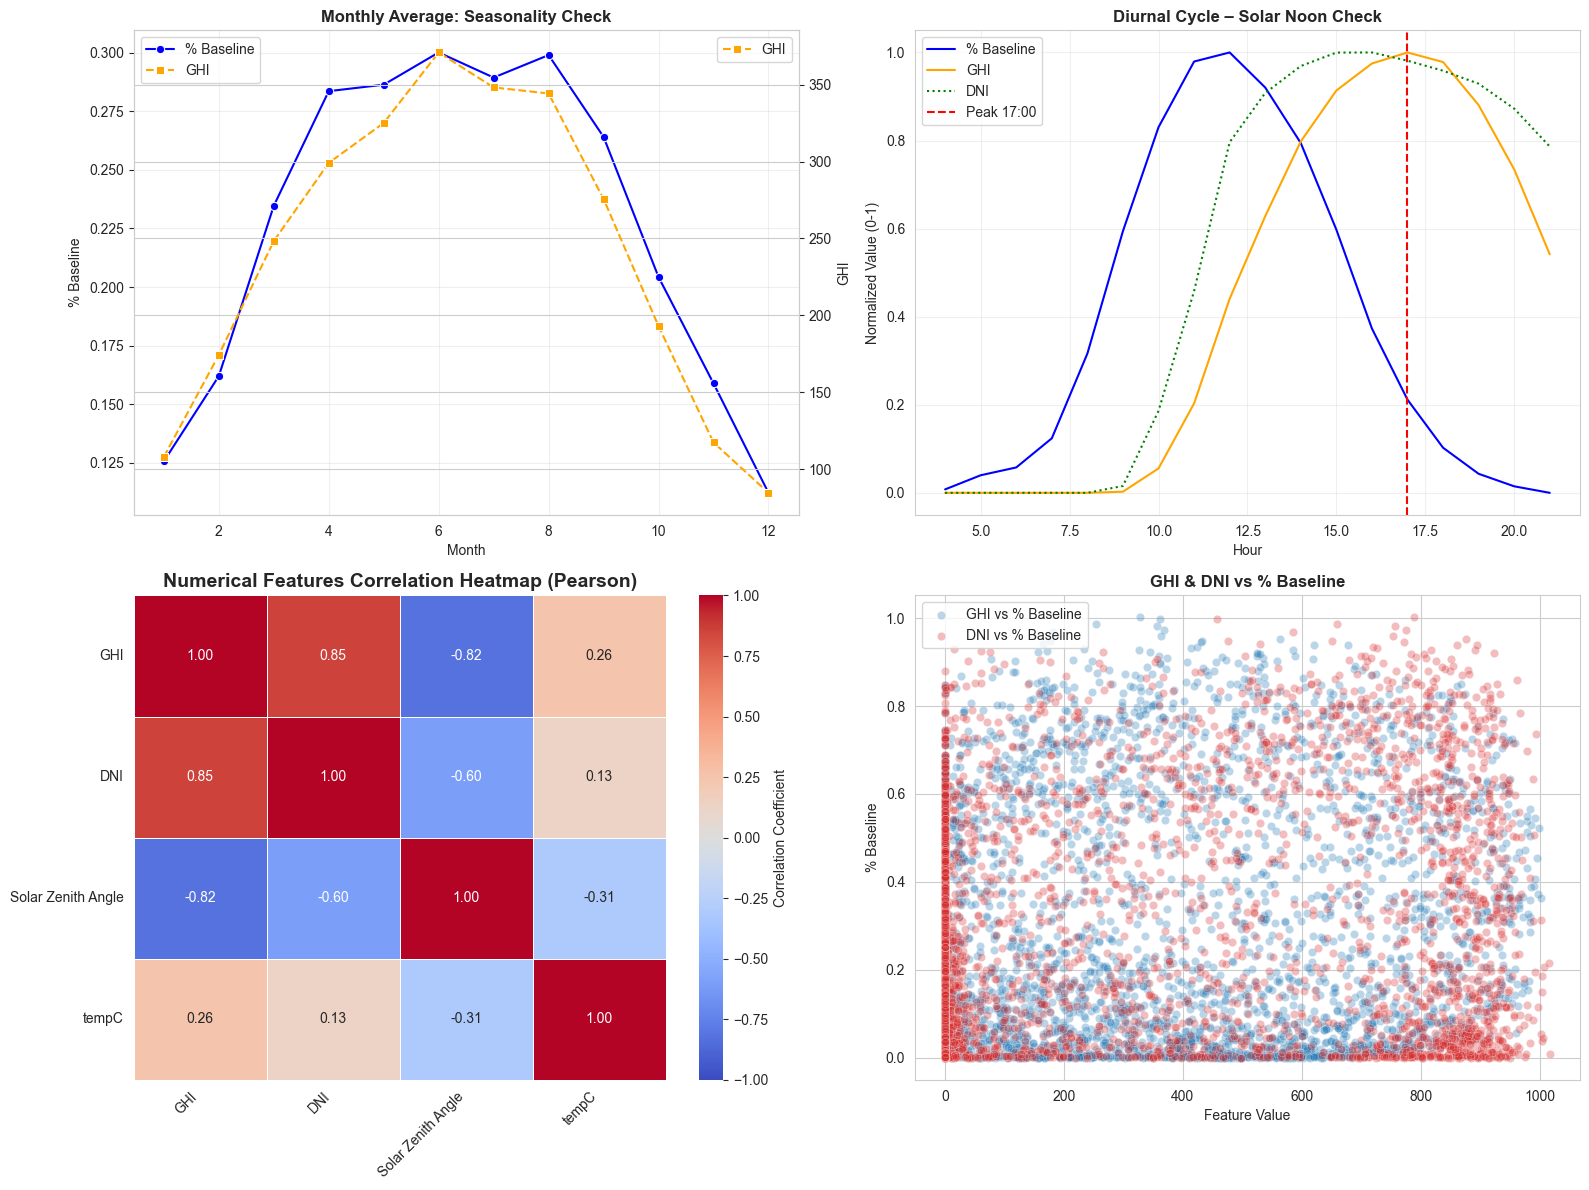

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

physics_features = ['GHI', 'DNI', 'Solar Zenith Angle', 'tempC']

explore.plot_monthly_seasonality(
    train, target='% Baseline', ax=axes[0,0],
    save_path=FIGURE_PATH/'astronomical/seasonality.png'
)
explore.plot_diurnal_cycle(
    train, target='% Baseline', ax=axes[0,1],
    save_path=FIGURE_PATH/"astronomical/diurnal_cycle.png"
)
explore.plot_numerical_correlation(
    train, numerical_features=physics_features, ax=axes[1,0],
    save_path=FIGURE_PATH/'astronomical/physics_heatmap.png'
)
explore.plot_two_feature_scatter(
    train, "GHI", "DNI", "% Baseline", ax=axes[1,1],
    save_path=FIGURE_PATH/"astronomical/irradiance_scatter.png"
)

plt.tight_layout()
plt.show()

`GHI` and `DNI` display clear seasonal and diurnal cycles that closely match variations in `% Baseline`, demonstrating that irradiance and solar geometry are the primary drivers of production. `Solar Zenith Angle` is strongly inversely related to irradiance and output, which confirms the expected physical relationship: higher sun angles (lower zenith) produce more available irradiance. The `GHI` vs `DNI` scatter is approximately linear at moderate-to-high irradiance, while increased dispersion at low `GHI` indicates cloud effects or transient atmospheric variability these same disturbances account for a large share of the residual variance in `% Baseline` at comparable irradiance levels.

For modeling, prioritize the irradiance measures (`GHI`, `DNI`) and `Solar Zenith Angle` as core predictors and include cloud/opacity indicators (e.g., `cloudcover`, `Cloud Type`) to explain low-irradiance scatter. Treat `tempC` as a secondary modifier (for example via interaction terms or high-sun subsets) rather than a primary driver. Consider engineering robust features for noise reduction: clearsky-normalized irradiance ratios, short rolling averages to smooth transients, and explicit diurnal/seasonal encodings (hour-of-day, month, or sin/cos transforms). Finally, flag and analyze low-irradiance periods separately during validation they represent physically different regimes (cloudy/overcast) where different model behavior and error characteristics are expected.

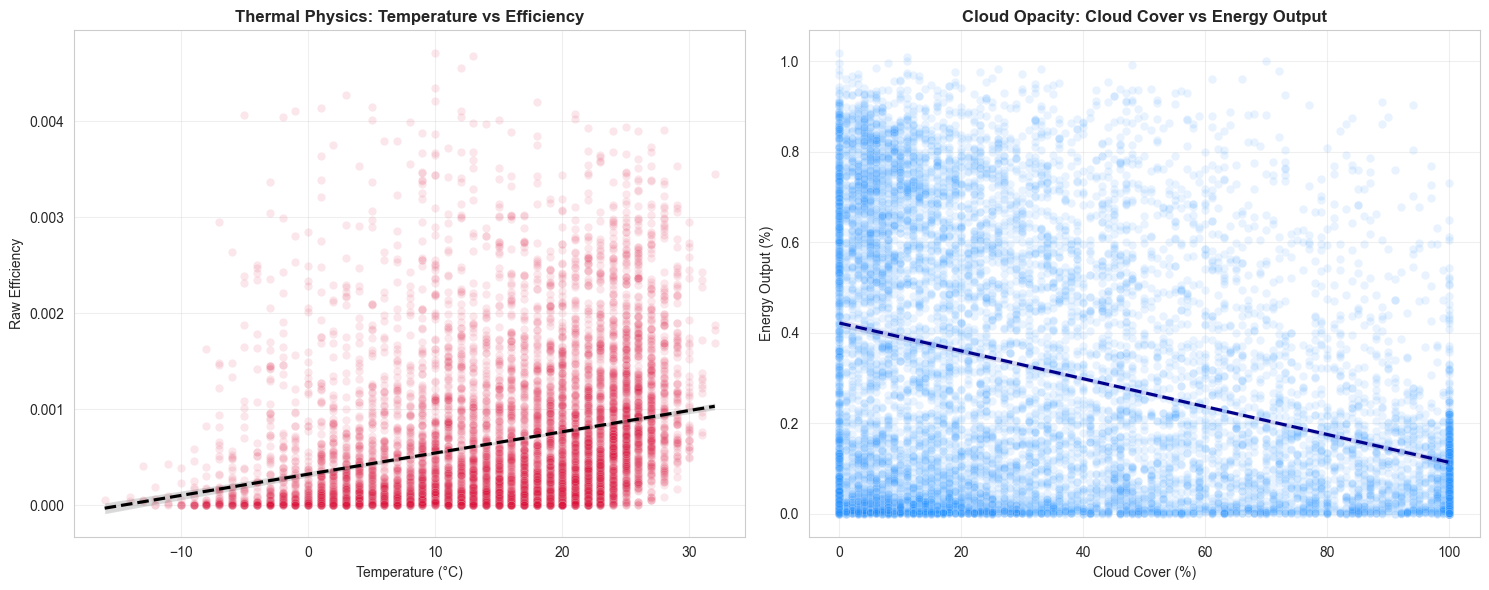

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

explore.plot_feature_vs_target(train, x="tempC", y="raw_efficiency", filter_mode="highsun",
                       color="crimson", reg_color="black", ax=axes[0],
                       title="Thermal Physics: Temperature vs Efficiency",
                       xlabel="Temperature (°C)", ylabel="Raw Efficiency",
                       save_path=FIGURE_PATH/'astronomical/temperature_vs_efficiency.png')

explore.plot_feature_vs_target(train, x="cloudcover", y="% Baseline", filter_mode="day",
                       color="dodgerblue", reg_color="darkblue", ax=axes[1],
                       title="Cloud Opacity: Cloud Cover vs Energy Output",
                       xlabel="Cloud Cover (%)", ylabel="Energy Output (%)",
                       save_path=FIGURE_PATH/'astronomical/cloudcover_vs_output')

plt.tight_layout()
plt.show()

`Temperature` vs `raw_efficiency` shows a small negative relationship. As `tempC` increases, raw efficiency tends to decrease slightly, which indicates thermal losses reduce panel performance but the overall effect is modest compared with irradiance.

`Cloud Cover` is associated with lower energy output. There is wide variability in `% Baseline` even at low `cloudcover` values, which suggests transient clouds and atmospheric conditions cause much of the scatter at low irradiance and that cloud indicators will help explain these deviations in models.

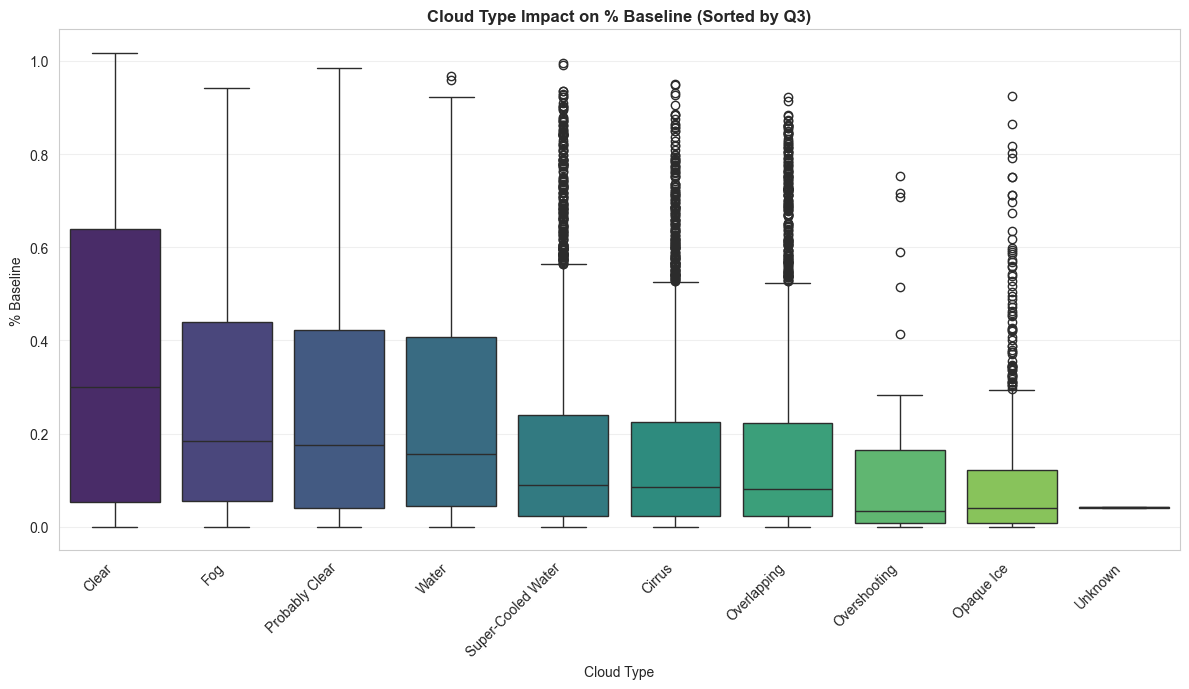

In [89]:
explore.plot_categorical_impact(train, category="Cloud Type", target="% Baseline", sort_by="Q3", palette='viridis',
                                filter_mode=None, save_path=FIGURE_PATH/'astronomical/cloudtype_impact.png')

plt.show()

# ⏱️ **Time Series Analysis**

In [105]:
train_timeseries = train.copy()
train_timeseries.Timestamp = pd.to_datetime(train_timeseries.Timestamp)
train_timeseries.set_index('Timestamp', inplace=True)

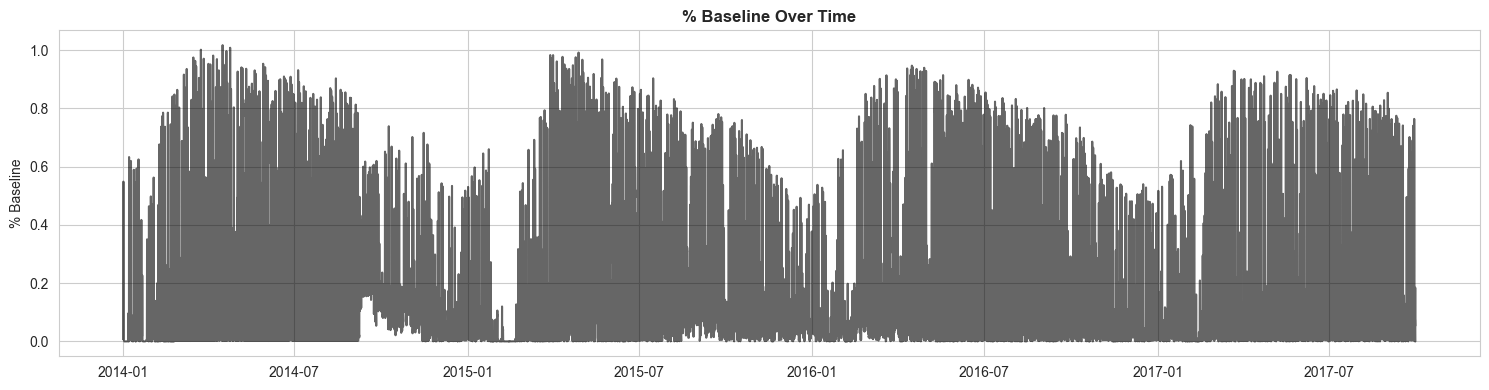

<Axes: title={'center': '% Baseline Over Time'}, ylabel='% Baseline'>

In [106]:
explore.plot_timeseries(train_timeseries, "% Baseline", color='Black')

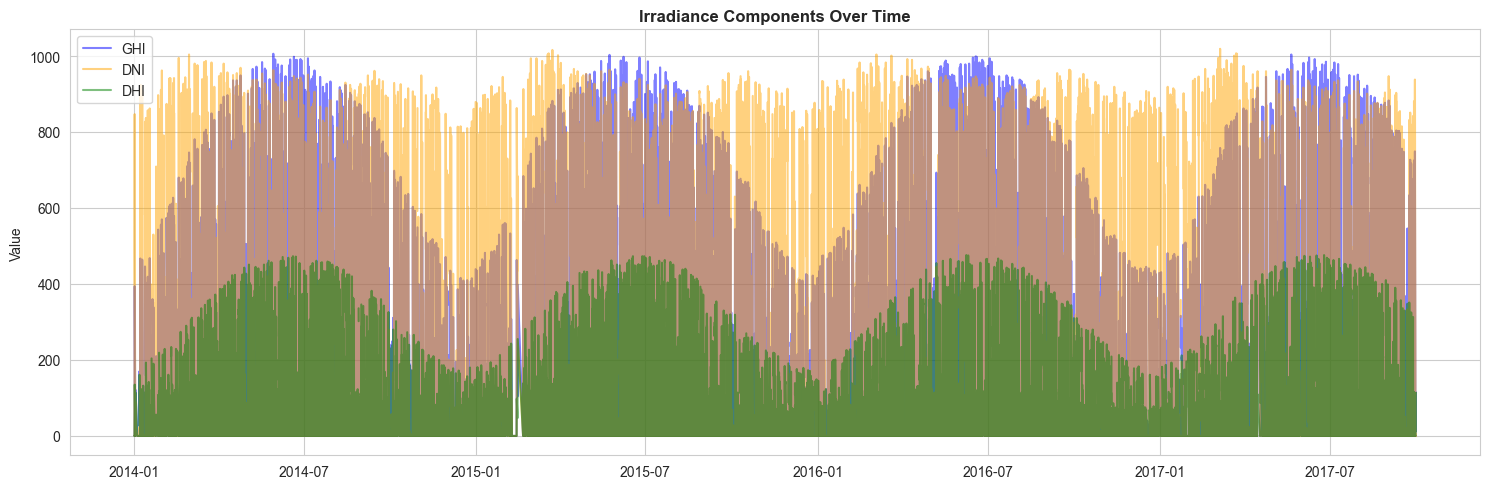

<Figure size 640x480 with 0 Axes>

In [107]:
explore.plot_overlay_timeseries(
    df=train_timeseries,
    columns=['GHI', 'DNI', 'DHI'],
    colors=['blue', 'orange', 'green'],
    title="Irradiance Components Over Time"
)

plt.tight_layout()
plt.show()

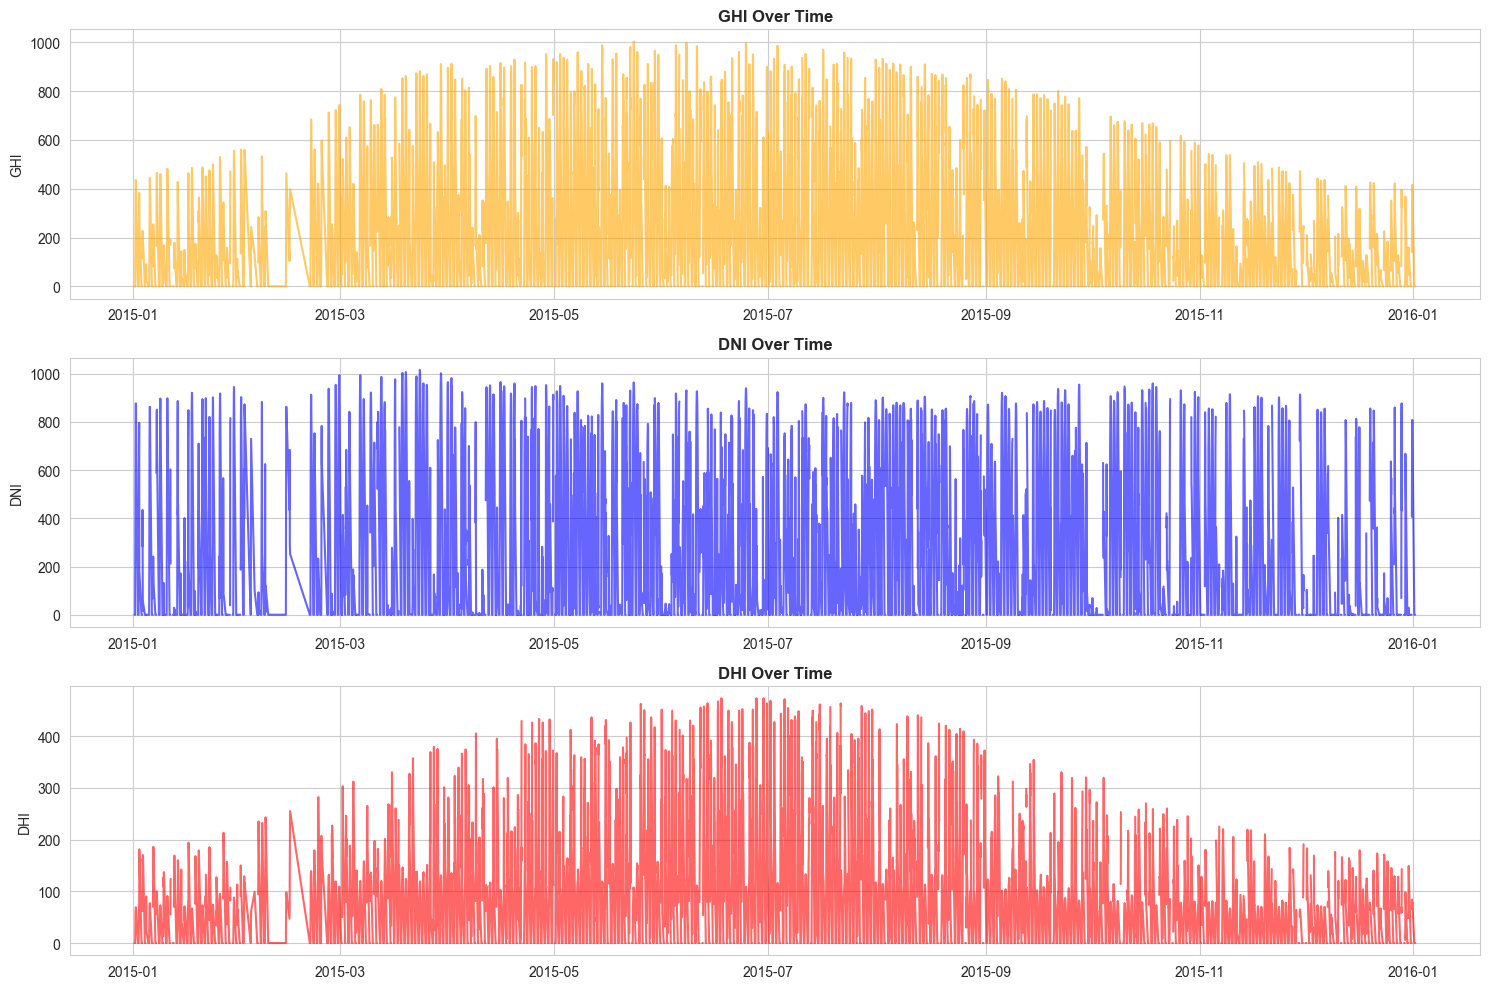

In [108]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

explore.plot_timeseries(train_timeseries,
                        start='2015-01-01', end='2016-01-01',
                        column="GHI", ax=ax[0], color='orange')

explore.plot_timeseries(train_timeseries,
                        start='2015-01-01', end='2016-01-01',
                        column="DNI", ax=ax[1], color='blue')

explore.plot_timeseries(train_timeseries,
                        start='2015-01-01', end='2016-01-01',
                        column="DHI", ax=ax[2], color='red')

plt.tight_layout()
plt.show()

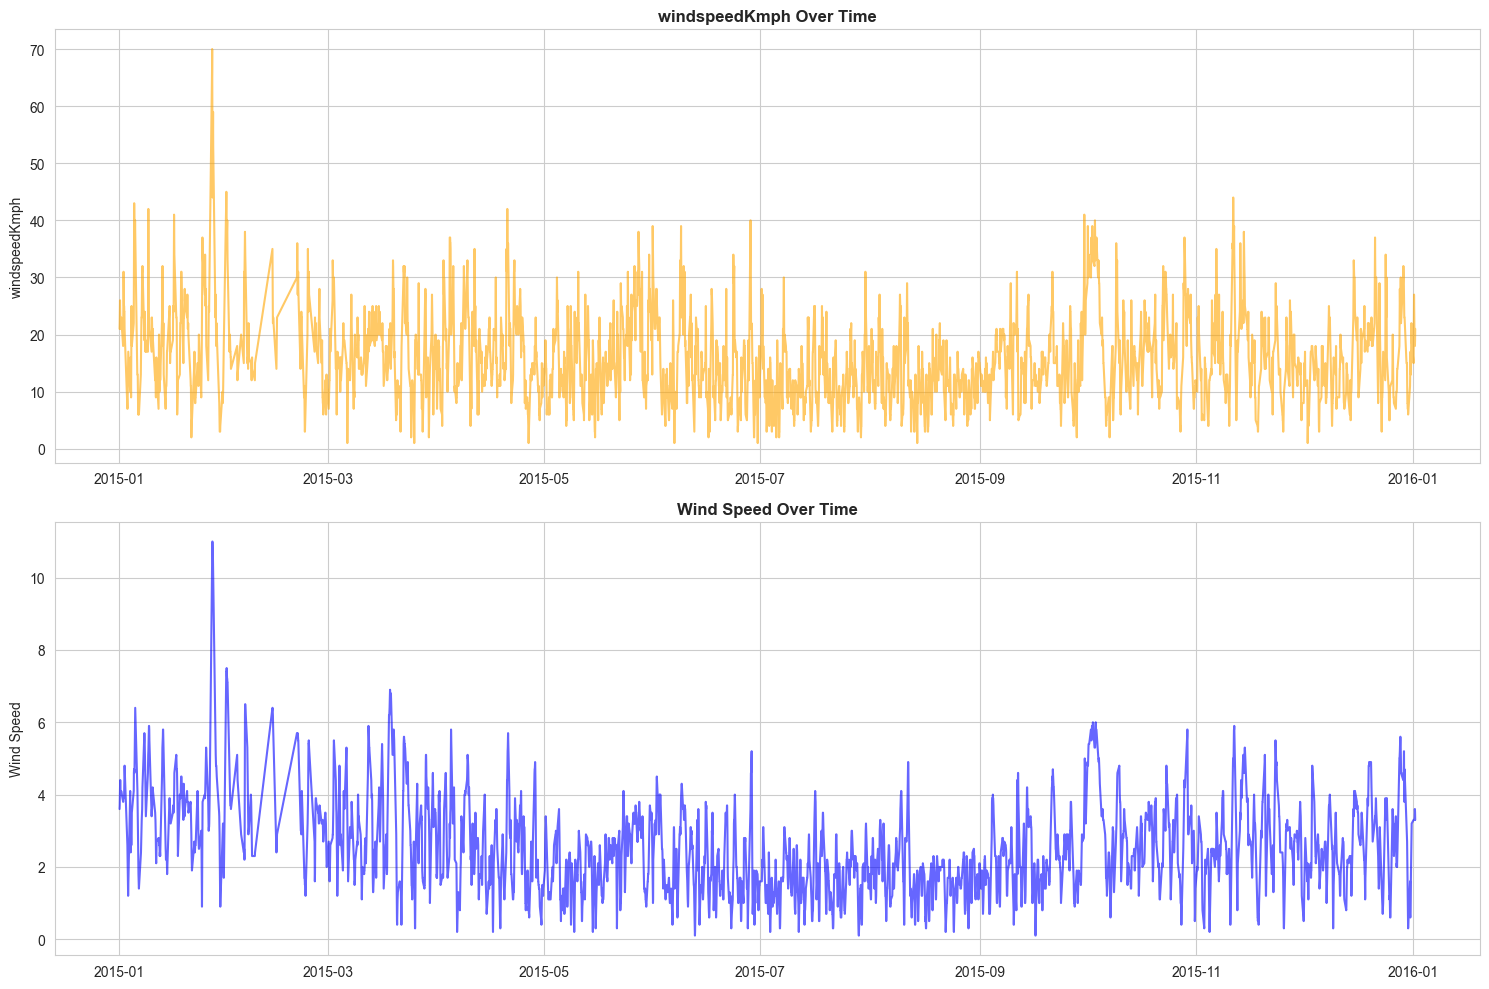

In [109]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

explore.plot_timeseries(train_timeseries,
                        start='2015-01-01', end='2016-01-01',
                        column="windspeedKmph", ax=ax[0], color='orange')
explore.plot_timeseries(train_timeseries,
                        start='2015-01-01', end='2016-01-01',
                        column="Wind Speed", ax=ax[1], color='blue')

plt.tight_layout()
plt.show()

In [110]:
clear_labels = ['Clear', 'Probably Clear']
train_timeseries['sky'] = (train_timeseries['Cloud Type']
                           .apply(lambda x: 'clear' if x in clear_labels else 'cloudy'))

In [111]:
train_timeseries['CSI'] = train_timeseries['GHI'] / train_timeseries['Clearsky GHI']

def classify_csi(csi):
    if csi >= 0.9:   return 'clear'
    elif csi >= 0.6: return 'partly'
    else:            return 'cloudy'

train_timeseries['sky'] = train_timeseries['CSI'].apply(classify_csi)

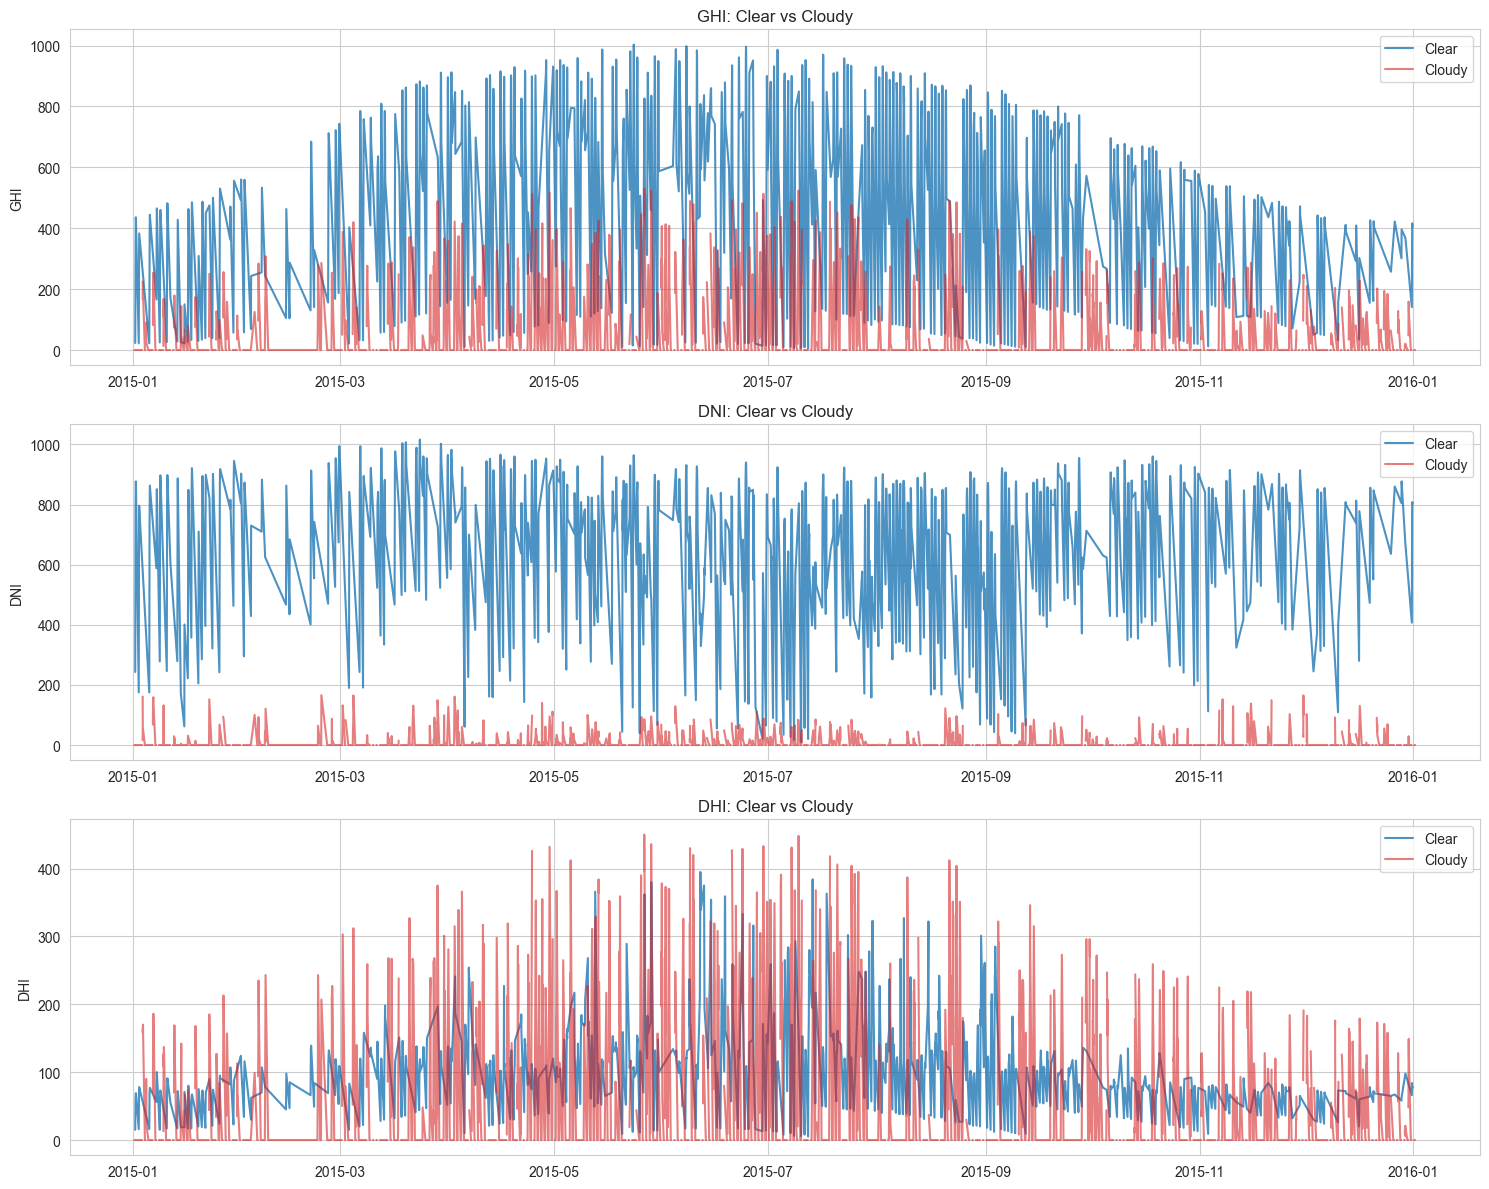

In [112]:
def compare_clear_cloudy(
    df, cols,
    start=None,
    end=None,
    sky_col='sky',
    clear_label='clear',
    cloudy_label='cloudy',
    figsize=(15,4),
    clear_color="#1f77b4",
    cloudy_color="#d62728",
    alpha_clear=0.8,
    alpha_cloudy=0.6,
    save_path=None
):
    df = df.loc[start:end] if (start or end) else df

    n = len(cols)
    fig, axes = plt.subplots(n, 1, figsize=(figsize[0], figsize[1] * n))

    # Ensure axes is always iterable
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, cols):
        ax.plot(
            df[df[sky_col] == clear_label][col],
            label=clear_label.capitalize(),
            color=clear_color,
            alpha=alpha_clear
        )
        ax.plot(
            df[df[sky_col] == cloudy_label][col],
            label=cloudy_label.capitalize(),
            color=cloudy_color,
            alpha=alpha_cloudy
        )

        ax.set_title(f"{col}: {clear_label.capitalize()} vs {cloudy_label.capitalize()}", fontsize=12)
        ax.set_ylabel(col)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig, axes


compare_clear_cloudy(
    df=train_timeseries,
    start='2015-01-01', end='2016-01-01',
    cols=['GHI', 'DNI', 'DHI'],
    sky_col='sky',
    clear_label='clear',
    cloudy_label='cloudy',
    figsize=(15,4),
    save_path=FIGURE_PATH/'timeseries/clear_vs_cloudy.png'
)

plt.tight_layout()
plt.show()

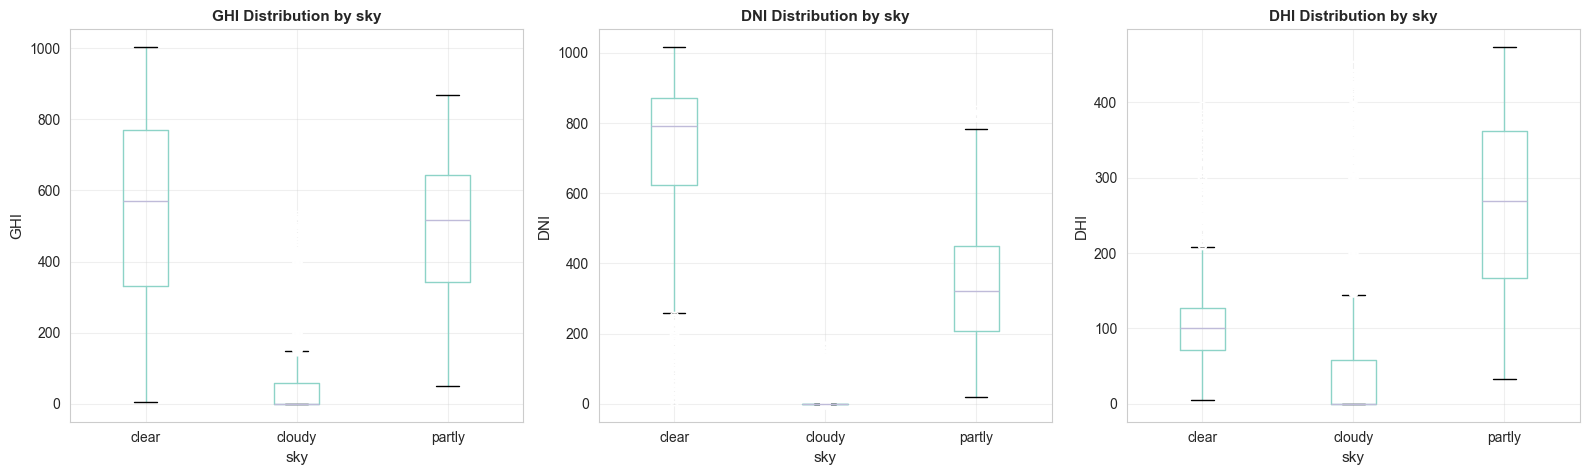

In [113]:
explore.boxplot_by_group(
    train_timeseries,
    start='2015-01-01', end='2016-01-01',
    columns=['GHI', 'DNI', 'DHI'],
    group_col='sky',
    figsize=(16,5),
    fontsize=11,
    save_path=FIGURE_PATH/'timeseries/sky_condition_boxplots.png'
)

plt.tight_layout()
plt.show()